Task 1: Data Extraction, Cleaning, and Exploratory Analysis for TSLA, BND, and SPY

1.	Extract Historical Financial Data

In [18]:
import sys
from pathlib import Path

# Project root
project_root = Path("D:/Personal/KAIM-10 Academy/Week 9/Project/portfolio-optimization-week9")

# Add src folder to sys.path
src_path = project_root / "src"
if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

print("✅ src path added to Python path:", sys.path[-1])
# Import modules directly, NOT with `src.` prefix
import data_loader as dl
import data_cleaning as dc
import data_reshape as dr
import eda as eda

print("✅ src modules imported successfully")

✅ src path added to Python path: D:\Personal\KAIM-10 Academy\Week 9\Project\portfolio-optimization-week9\src
✅ src modules imported successfully


Extract Historical Financial Data (TSLA, BND, SPY)

In [35]:
# Paths
raw_file = project_root / "data/raw/all_assets_raw.csv"

# Load if exists, otherwise fetch from yfinance

try:
    df_raw = dl.fetch_market_data(tickers=["TSLA","BND","SPY"])
    print(f"✅ Data fetched | Rows: {len(df_raw)}, Columns: {len(df_raw.columns)}")
except Exception as e:
    print("❌ Error fetching data:", e)
    raise

# Quick preview
display(df_raw.head())



✅ Data fetched | Rows: 8325, Columns: 3


,Date,Ticker,Price
0,2015-01-02,BND,60.385944
1,2015-01-05,BND,60.561317
2,2015-01-06,BND,60.736664
3,2015-01-07,BND,60.773205
4,2015-01-08,BND,60.678192


2. Data Cleaning and Understading 

In [41]:
# -------------------------
# Inspect Raw Data
# -------------------------
print("\n--- Raw Data Preview ---")
display(df_raw.head())
print(f"Number of rows: {len(df_raw)}, Number of columns: {len(df_raw.columns)}")
print("\nData types:\n", df_raw.dtypes)
print("\nMissing values:\n", df_raw.isna().sum())

# -------------------------
# Basic Statistics
# -------------------------
numeric_cols = ["Price"]
print("\n--- Basic Statistics ---")
display(df_raw[numeric_cols].describe())

# -------------------------
# Data Cleaning
# -------------------------
# Convert Price to numeric (in case)
df_clean = dc.clean_data(df_raw, numeric_cols=numeric_cols)

# Fill missing numeric values per Ticker
df_clean[numeric_cols] = df_clean.groupby("Ticker")[numeric_cols] \
                                  .transform(lambda x: x.ffill().bfill().interpolate())

# convert Ticker to category
df_clean["Ticker"] = df_clean["Ticker"].astype("category")

# Per-ticker statistics
for ticker in df_clean["Ticker"].unique():
    print(f"\nStats for {ticker}:")
    display(df_clean[df_clean["Ticker"] == ticker][numeric_cols].describe())

# Verify cleaned data
print("\n✅ Data cleaned")
print("Shape:", df_clean.shape)
print("\nData types after cleaning:\n", df_clean.dtypes)
print("\nMissing values after cleaning:\n", df_clean.isna().sum())

# -------------------------
# Normalization / Scaling (0–1 for ML)
# -------------------------
df_scaled = dc.scale_data(df_clean, numeric_cols=numeric_cols)
print("\n✅ Price column normalized (0–1) for ML models")

# -------------------------
# Save cleaned & scaled data
# -------------------------
df_scaled.to_csv(processed_file, index=False)
print("\n✅ Cleaned & normalized data saved to:", processed_file)



--- Raw Data Preview ---


,Date,Ticker,Price
0,2015-01-02,BND,60.385944
1,2015-01-05,BND,60.561317
2,2015-01-06,BND,60.736664
3,2015-01-07,BND,60.773205
4,2015-01-08,BND,60.678192


Number of rows: 8325, Number of columns: 3

Data types:
 Date      datetime64[s]
Ticker              str
Price           float64
dtype: object

Missing values:
 Date      0
Ticker    0
Price     0
dtype: int64

--- Basic Statistics ---


,Price
count,8325.000000
mean,181.624463
std,160.434449
min,9.578000
25%,63.490875
50%,91.625999
75%,266.860352
max,695.159973



Stats for BND:


,Price
count,2775.000000
mean,67.325728
std,4.685295
min,59.698620
25%,63.436455
50%,66.492096
75%,71.237343
max,76.068092



Stats for SPY:


,Price
count,2775.000000
mean,339.074724
std,141.925745
min,154.980881
25%,219.599678
50%,301.538574
75%,423.938461
max,695.159973



Stats for TSLA:


,Price
count,2775.000000
mean,138.472937
std,131.682073
min,9.578000
25%,17.851666
50%,91.625999
75%,242.028336
max,489.880005



✅ Data cleaned
Shape: (8325, 3)

Data types after cleaning:
 Date      datetime64[s]
Ticker         category
Price           float64
dtype: object

Missing values after cleaning:
 Date      0
Ticker    0
Price     0
dtype: int64

✅ Price column normalized (0–1) for ML models

✅ Cleaned & normalized data saved to: D:\Personal\KAIM-10 Academy\Week 9\Project\portfolio-optimization-week9\data\processed\all_assets_clean.csv


Exploratory Data Analysis (EDA)

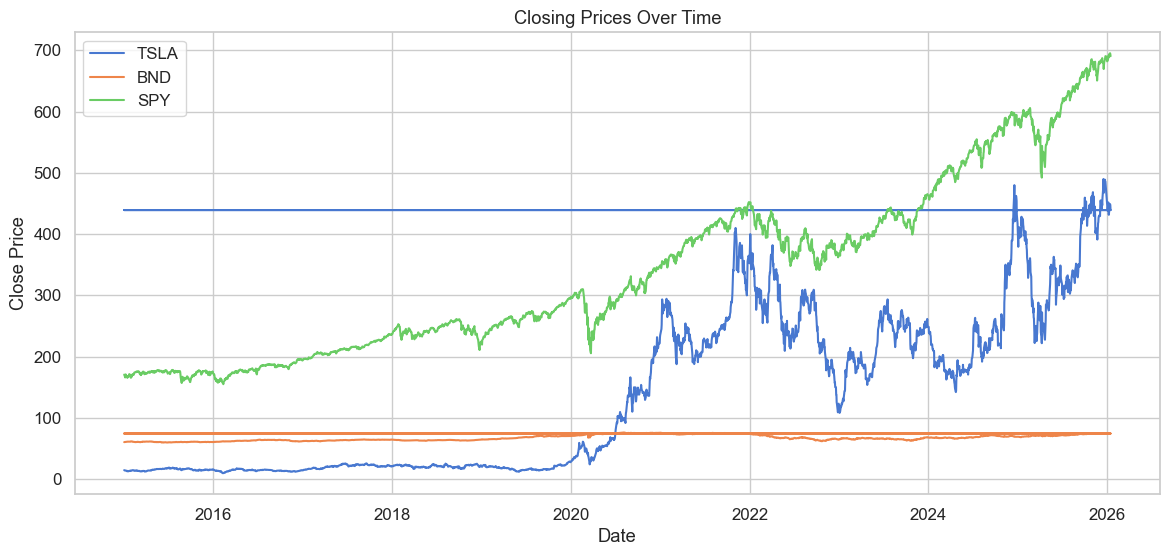

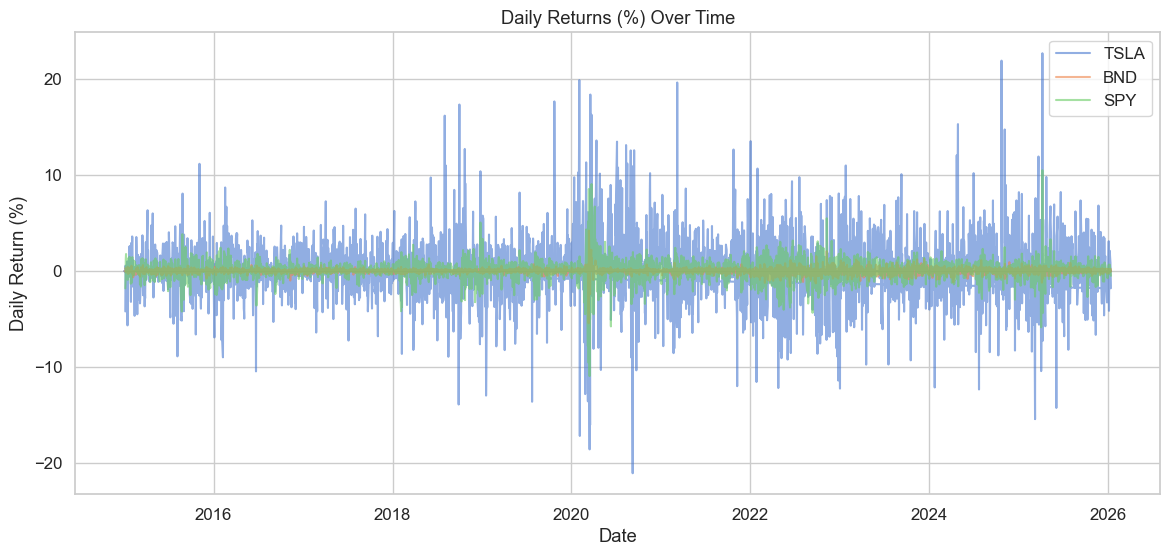

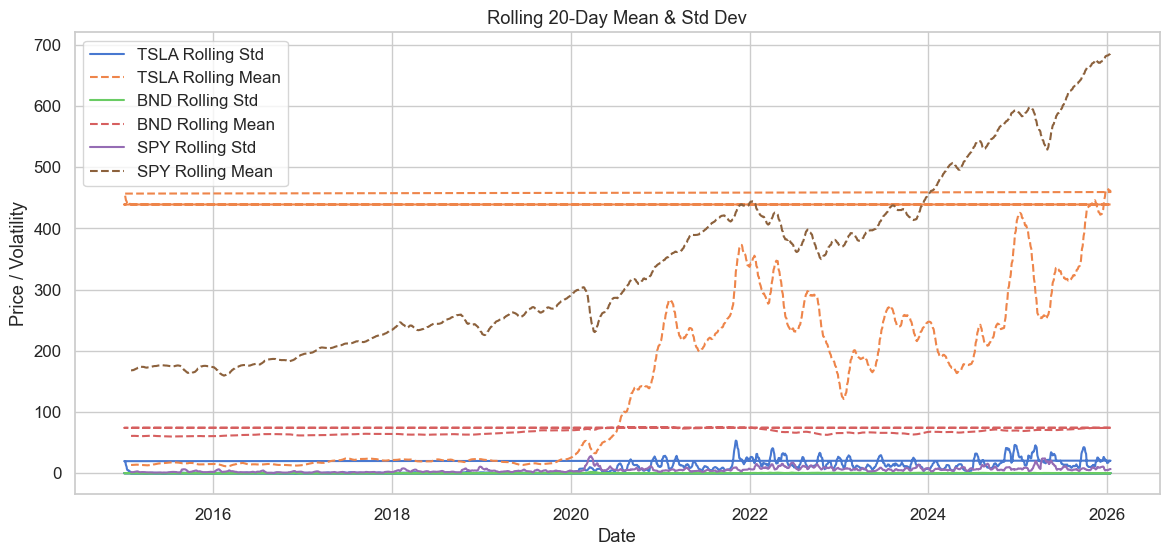

In [42]:
#Closing Prices Over Time
eda.plot_closing_prices(df_long)

#Daily returns
eda.plot_daily_returns(df_long)

#Rolling Mean Volatility 
eda.plot_rolling_stats(df_long, window=20)

In [9]:
#Outlier Detection
outliers = eda.detect_outliers(df_long, threshold=3)
print("Number of extreme return days per ticker:")
for ticker in df_long["Ticker"].unique():
    print(f"{ticker}: {len(outliers[outliers['Ticker']==ticker])}")

Number of extreme return days per ticker:
TSLA: 213
BND: 92
SPY: 39


Seasonality & Trend Analysis

,Ticker,ADF Statistic,p-value,Used Lag,Number of Observations,Stationary
0,TSLA,-1.977103,0.296702,35,8289,False
1,BND,-2.082290,0.251695,32,5517,False
2,SPY,1.170880,0.995778,9,2765,False


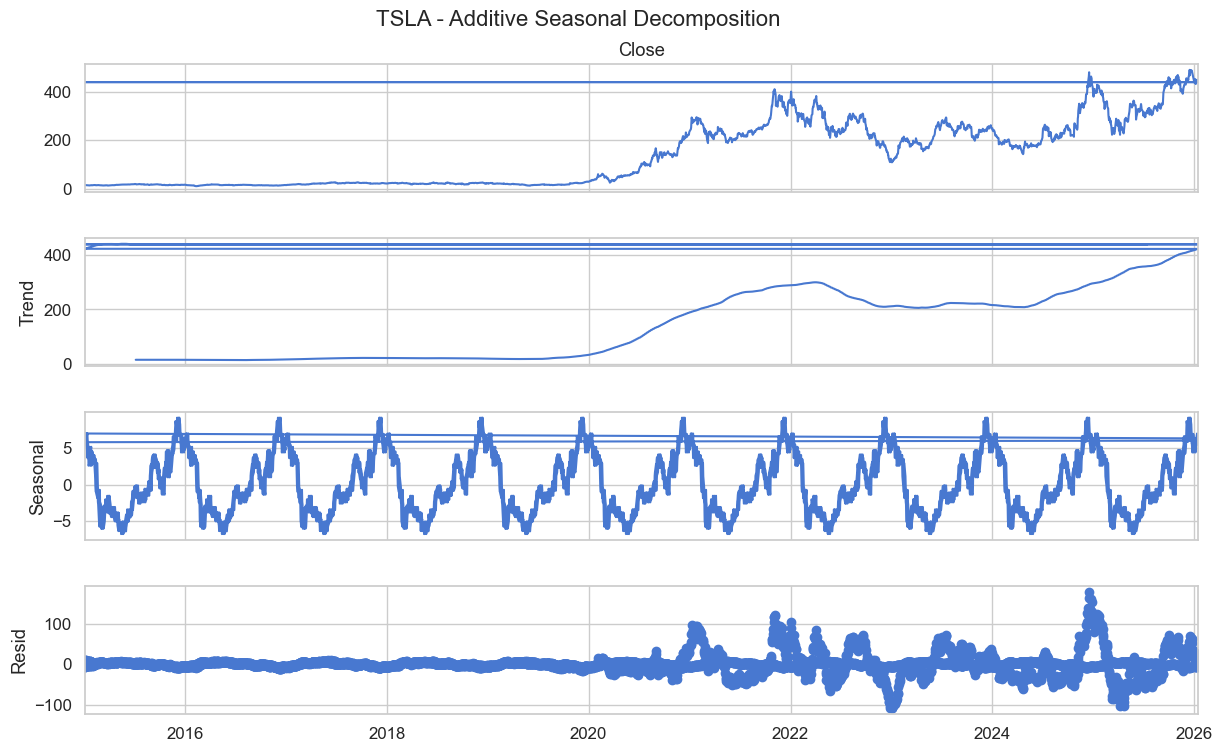

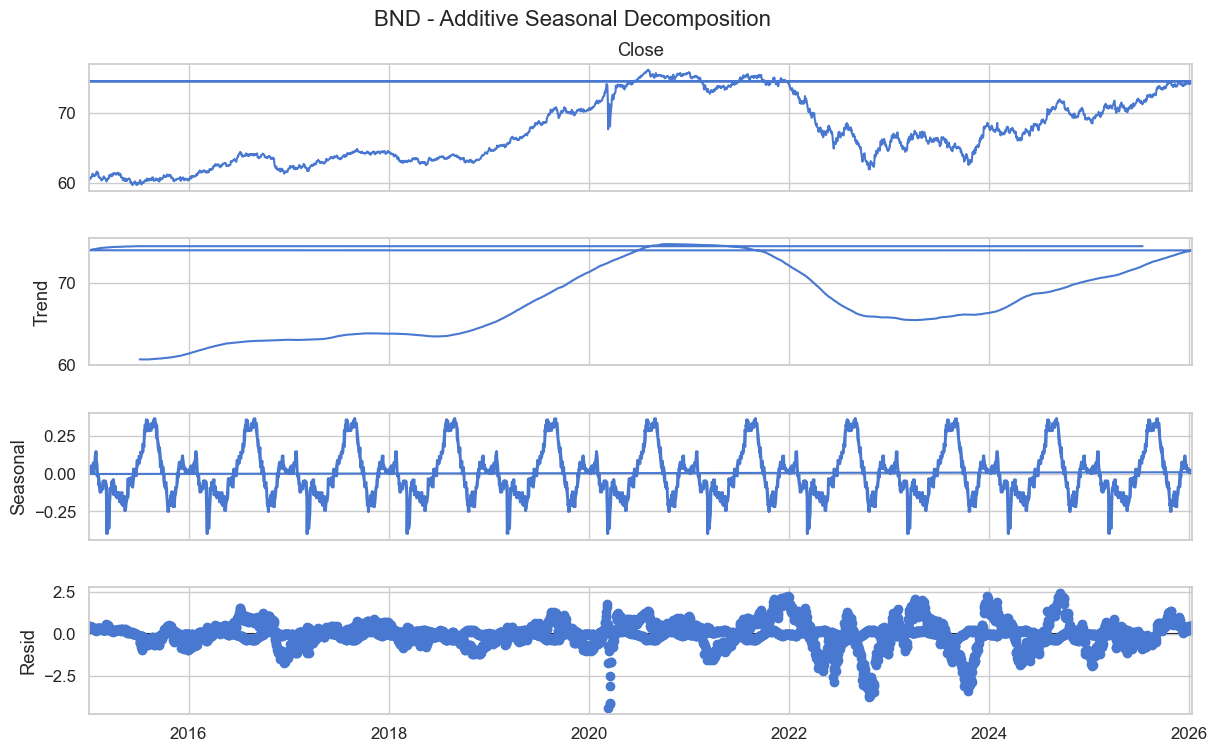

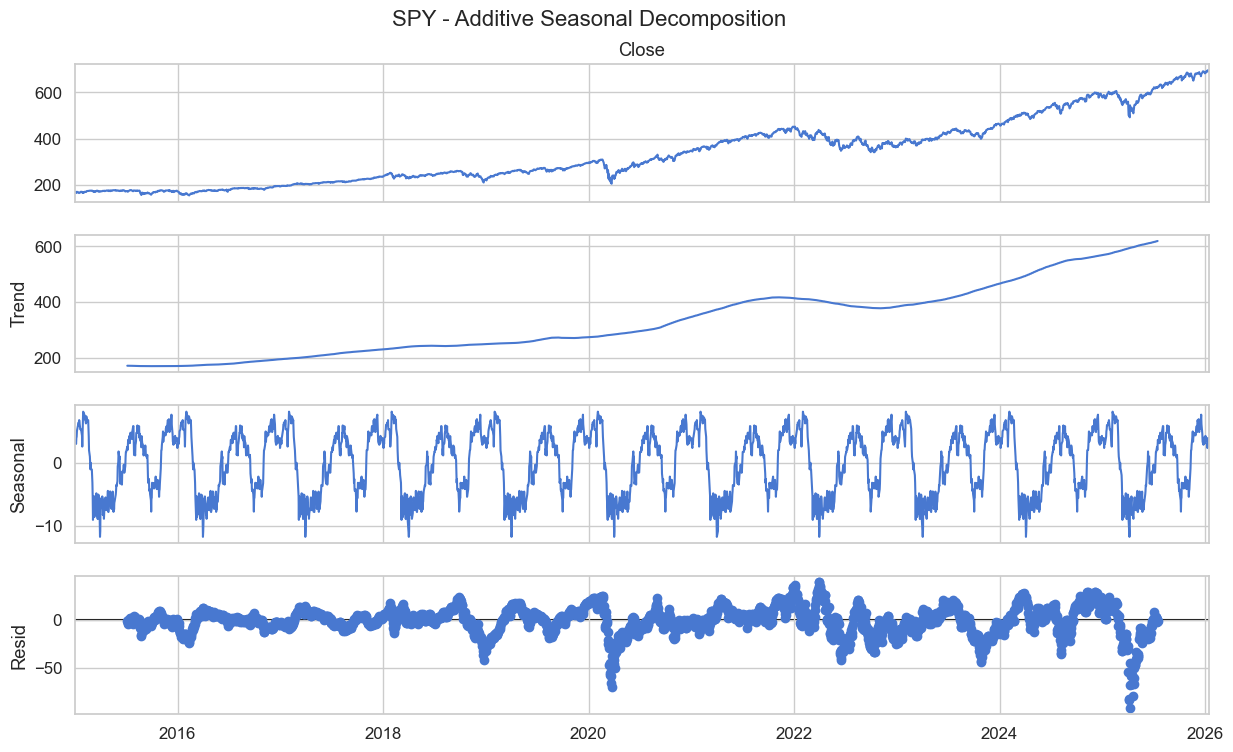

In [11]:
#Augmented Dickey-Fuller Test (ADF)
adf_results = eda.adf_test_series(df_long)
display(adf_results)

#Seasonal Decomposition
eda.plot_decomposition(df_long, column="Close", model="additive", freq=252)

Risk Metrics

In [14]:
#Vakue at Risk (VaR)
var_results = eda.calculate_var(df_long)
print("=== Value at Risk (95%) ===")
display(var_results)

#SHarp Ratios
sharpe_results = eda.calculate_sharpe(df_long)
print("=== Sharpe Ratios ===")
display(sharpe_results)

#Key Insights SUmmary
for ticker in df_long["Ticker"].unique():
    tmp = df_long[df_long["Ticker"] == ticker]
    print(f"{ticker}: Mean Daily Return = {tmp['Daily_Return'].mean():.4f}%, Std Dev = {tmp['Daily_Return'].std():.4f}%")
    print(f"VaR (95%) = {var_results[var_results['Ticker']==ticker]['VaR_95'].values[0]:.2f}%")
    print(f"Annualized Sharpe Ratio = {sharpe_results[sharpe_results['Ticker']==ticker]['Sharpe_Annual'].values[0]:.2f}")
    print("---")

=== Value at Risk (95%) ===


,Ticker,VaR_95
0,TSLA,2.878320
0,BND,0.329665
0,SPY,1.671900


=== Sharpe Ratios ===


,Ticker,Sharpe_Daily,Sharpe_Annual
0,TSLA,0.029912,0.474840
0,BND,0.016989,0.269692
0,SPY,0.050647,0.803992


TSLA: Mean Daily Return = 0.0628%, Std Dev = 2.0996%
VaR (95%) = 2.88%
Annualized Sharpe Ratio = 0.47
---
BND: Mean Daily Return = 0.0041%, Std Dev = 0.2386%
VaR (95%) = 0.33%
Annualized Sharpe Ratio = 0.27
---
SPY: Mean Daily Return = 0.0567%, Std Dev = 1.1193%
VaR (95%) = 1.67%
Annualized Sharpe Ratio = 0.80
---


In [43]:
# =========================
# 6️⃣ Key Findings & Recommendations
# =========================

print("📊 === Key Findings from Task 1 === 📊\n")

print("1️⃣ TSLA (Tesla) is highly volatile:")
print("   - Std Dev of daily returns ≈ 2.10%")
print("   - 213 extreme return days (|z-score| > 3)")
print("   - High potential for large gains and losses\n")

print("2️⃣ SPY (S&P 500 ETF) shows moderate volatility:")
print("   - Std Dev ≈ 1.12%")
print("   - 39 extreme return days")
print("   - Suitable for balanced growth\n")

print("3️⃣ BND (Bond ETF) is very stable:")
print("   - Std Dev ≈ 0.24%")
print("   - 92 extreme return days")
print("   - Ideal for low-risk, portfolio stabilization\n")

print("4️⃣ Risk Metrics Analysis:")
print("   - Value at Risk (95%): TSLA = 2.88%, SPY = 1.67%, BND = 0.33%")
print("   - Annualized Sharpe Ratios: TSLA = 0.47, SPY = 0.80, BND = 0.27\n")

print("5️⃣ Stationarity & Seasonality:")
print("   - ADF test shows none of the series are stationary")
print("   - Seasonal decomposition reveals yearly trends and cycles")
print("   - Transformation or differencing needed before time series modeling\n")

print("💡 === Recommendations === 💡\n")
print("• Use BND to mitigate risk in portfolio construction.")
print("• TSLA should have risk-adjusted allocation or hedging strategies.")
print("• Apply ARIMA/LSTM forecasting on detrended or differenced data.")
print("• Monitor extreme return days for TSLA for active risk management.")
print("• Use SPY for a moderate-risk growth component in the portfolio.\n")

print("✅ Task 1 complete: Data cleaned, normalized, analyzed, and key insights summarized!")


📊 === Key Findings from Task 1 === 📊

1️⃣ TSLA (Tesla) is highly volatile:
   - Std Dev of daily returns ≈ 2.10%
   - 213 extreme return days (|z-score| > 3)
   - High potential for large gains and losses

2️⃣ SPY (S&P 500 ETF) shows moderate volatility:
   - Std Dev ≈ 1.12%
   - 39 extreme return days
   - Suitable for balanced growth

3️⃣ BND (Bond ETF) is very stable:
   - Std Dev ≈ 0.24%
   - 92 extreme return days
   - Ideal for low-risk, portfolio stabilization

4️⃣ Risk Metrics Analysis:
   - Value at Risk (95%): TSLA = 2.88%, SPY = 1.67%, BND = 0.33%
   - Annualized Sharpe Ratios: TSLA = 0.47, SPY = 0.80, BND = 0.27

5️⃣ Stationarity & Seasonality:
   - ADF test shows none of the series are stationary
   - Seasonal decomposition reveals yearly trends and cycles
   - Transformation or differencing needed before time series modeling

💡 === Recommendations === 💡

• Use BND to mitigate risk in portfolio construction.
• TSLA should have risk-adjusted allocation or hedging strategies